In [1]:
experiment_setup_name = "wikicat.long_run.category_focused.10s_batch.nesterov.3layer"

In [2]:
import sys
sys.path.append("..")

In [3]:
#import everything in the world
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2
import pandas as pd
!mkdir ~/agentnet_snapshots


Couldn't import dot_parser, loading of dot files will not be possible.
mkdir: cannot create directory '/root/agentnet_snapshots': File exists


In [4]:
floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* two layers of GRU memory
* Qvalues predicted via dense layer from both memory layers
* epsilon-greedy decision making
* trained with Nesterov Mommentum SGD

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 393 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [5]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


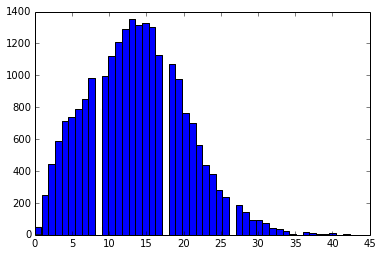

In [6]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [7]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [10]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.5,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 4297
контрольная выборка: 4297


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [63]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = _shared("batch_size_scalar",batch_size,'int32')
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1
).astype('float32') #it is highly important to make sure 
        #that variables touched by theano.grad have float* type
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)
        set_shared(self._batch_size,attrs_batch.shape[0])

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
        
    
    def get_action_results(self,last_state,action,time_i):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,session_states,session_actions,batch_i):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[time_i, memory_id]: environment state before taking action
            session_actions int[time_i]: agent action at this tick
        returns:
            reward float[time_i]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _has_finished_now = T.set_subtensor(_has_finished_now[-1],1)
        
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
                
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-1,
            _response*2-1
        )
        
        #on session end: -6 if not guessed any categories, -3 otherwise
        _at_least_one_category_guessed = T.any(_action_is_categorical & _response.astype('int8'))

        #ending session
        _reward_for_end_action = T.switch(_at_least_one_category_guessed, #if guessed at least 1 category
                                          0,   #do not penalize
                                          -5.)  #else punish
        
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            _reward_for_end_action,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [64]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [65]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [66]:
import lasagne
__idea__="""
 
We train two memory states:
    first one, based on observations, and second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.

"""
n_hid_1=256 #first GRU memory
n_hid_2=128 #second GRU memory
n_hid_3=128 #second GRU memory


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer([None,n_hid_2],name="prev_gru2_state_input")
_prev_gru3_layer = lasagne.layers.InputLayer([None,n_hid_3],name="prev_gru3_state_input")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     _observation_layer,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

gru3 = GRUMemoryLayer(n_hid_3,
                     gru2,        #note that it takes CURRENT gru2 output as input.
                                  #replacing that with _prev_gru2_state would imply taking previous one.
                     _prev_gru3_layer,
                     name="gru3")


concatenated_memory = lasagne.layers.concat([gru1,gru2,gru3])

#q_eval
q_eval = lasagne.layers.DenseLayer(concatenated_memory, #taking both memories. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#we need to define the new input map because concatenated_memory is a ConcatLayer and does not have default one

def custom_input_map(last_hidden,observation):
    """just a function that maps memory states to respective inputs"""
    return {
        _prev_gru1_layer:last_hidden[:,0:n_hid_1],
        _prev_gru2_layer:last_hidden[:,n_hid_1:n_hid_1+n_hid_2],
        _prev_gru3_layer:last_hidden[:,n_hid_1+n_hid_2:n_hid_1+n_hid_2+n_hid_3],
        _observation_layer:observation
    }

#all together
agent = Agent(concatenated_memory,q_eval,resolver,input_map=custom_input_map
             )


In [67]:
history = agent.get_sessions(env,session_length=20,
                       batch_size=env._joint_data.shape[0],)
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [68]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [69]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 gru3.W_in_to_updategate,
 gru3.W_hid_to_updategate,
 gru3.b_updategate,
 gru3.W_in_to_resetgate,
 gru3.W_hid_to_resetgate,
 gru3.b_resetgate,
 gru3.W_in_to_hidden_update,
 gru3.W_hid_to_hidden_update,
 gru3.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [70]:
#all weights but for Qvalues prediciton ones (not to penalize q-predictors by l2)
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 gru3.W_in_to_updategate,
 gru3.W_hid_to_updategate,
 gru3.b_updategate,
 gru3.W_in_to_resetgate,
 gru3.W_hid_to_resetgate,
 gru3.b_resetgate,
 gru3.W_in_to_hidden_update,
 gru3.W_hid_to_hidden_update,
 gru3.b_hidden_update]

# целевая функция для обучения сети

* Интуитивно, цель - предсказывать Q-значения (полезности) действий
* $Q(s,a) = R(s,a) + gamma* Max_{a'}{ Q(s',a')}  $
 * R(s,a) - непосредственная награда за действие (+5 если угадал, -1 если нет и т.п.)
 * s' - состояние, в которое агент попал, сделав действие a из состояния s
 * a' - действие, которое можно совершить в состоянии s'
 * gamma - во сколько раз награда/пинок через 1 шаг менее значимы, чем сейчас
 * интуиция - "в состоянии s полезность действия a - это непосредственная печенька за это действие ПЛЮС все печеньки, которые можно собрать, если после этого действия вести себя оптимально"
 
* В реальном мире оптимизируются попарно 2 приближения этой функции
* $ RMSE_{reccurent}: (NN_s(a) - (R + gamma* Max_a'{ NN_s'(a')})^2$
 * NN_s(a) предсказаннная из состояния s полезност Q(s,a)
 * считается для тех NN_s(a), которые агент совершил
 * NN_s'(a') - полезности всех действий сразу после совершения a из состяния s

* $ RMSE_{naive}: (NN_s(a^*) - (R + gamma*  NN_s'(a'^*))^2$
 * аналогично предыдущему, но a* - реально совершённое агентом действие
 * оценка смещена, но куда проще оптимизируется, чем предыдущая
   * по крайней мере, с softmax принятием решений

In [71]:
#get pairs of corresponding [predicted Qvalues, reference Qvalues] to train on

is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)

ref_tuples = env.get_reference(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_Qvalues, predicted_Qvalues, is_end = ref_tuples

In [72]:
#concatenate "alive" ticks from all sessions to then compute errors

to_be_raveled = [action_seq,rewards_seq,action_Qvalues, predicted_Qvalues, is_end]

raveled_tuples = env.ravel_alive(is_alive_seq,*to_be_raveled)

action_ids_ravel,immediate_rewards_ravel,action_Qvalues_ravel,\
reference_Qvalues_ravel,is_end_ravel= raveled_tuples



from auxilary import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

In [73]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,action_Qvalues_ravel).mean()

In [74]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [75]:
loss = loss_recurrent + reg_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [76]:
_updates = lasagne.updates.nesterov_momentum(loss,weights,learning_rate=0.01,momentum=0.9)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [77]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation
* удобная [мне одному] функция, которая показывает примеры сессий и внутреннее состояние нейронки
* текстовая часть - 
    * #(номер_действия) (имя_действия) (предсказанное_Qvalue) -> (награда) | следующая итерация
* картинка (если display = True)
    * X - моменты времени, Y - попугаи
    * жЫрные линии - Q-значения категорий
    * тонкие линии - Q-значения узнавания аттрибутов
    * точки на линиях - выбранные действия
    * пунктирные линии - активация нейронов в памяти агента
    * синяя черта (тонкая, вертикальная) - конец сессии (действие или лимит времени)


In [78]:
evaluation_fun = theano.function([],[action_ids_ravel,action_Qvalues_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [79]:
#new names order
feature_names = list(data_attrs.columns) + list(data_cats.columns) + ["<end_session_action>"]
is_categorical = lambda i: feature_names[i].startswith("category:")

def print_session(n_sessions = 3,display=False,legend=True):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i],linewidth = 1 + 4*is_categorical(i))

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                if legend:
                    plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


# training

In [80]:
def load_random_batch(env,attrs,cats,batch_size=10):
    
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [81]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [82]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.
ma_reward_test = 0.

# само обучение
* шаг алгоритма - 
 * выбрать B случайных людей
 * пересчитать "жадность" алгоритма (чем дальше, тем более жадный)
 * сделать шаг обучения
 * раз в M итераций - добавить точку на график обучения по 3 метрикам
   * ожидание награды за сессию при текущей жадности на тренировочных данных
   * то же самое при максимальной жадности
 * раз в N итераций - 
   * показать несколько примеров сессий на обучающих данных при разной жадности
   * показать графики обучения
* раз в K итераций - записать веса нейронки в файл (snapshot)

epoch 100,loss 1.62088, greed 0.20090, rewards: ( train -18.59476, det_train 0.00000) 
rec 1.620 reg 0.001
epoch 200,loss 3.48630, greed 0.20180, rewards: ( train -15.77822, det_train 0.14000) 
rec 3.485 reg 0.001
epoch 300,loss 2.52026, greed 0.20270, rewards: ( train -16.62272, det_train 0.06600) 
rec 2.519 reg 0.001
epoch 400,loss 2.01430, greed 0.20359, rewards: ( train -16.57658, det_train -0.06060) 
rec 2.013 reg 0.001
epoch 500,loss 0.94860, greed 0.20449, rewards: ( train -16.24839, det_train 0.13546) 
rec 0.948 reg 0.001
epoch 600,loss 2.37696, greed 0.20538, rewards: ( train -16.94781, det_train 0.00191) 
rec 2.376 reg 0.001
epoch 700,loss 1.40229, greed 0.20628, rewards: ( train -17.02183, det_train -0.02828) 
rec 1.401 reg 0.001
epoch 800,loss 1.93842, greed 0.20717, rewards: ( train -15.87624, det_train -0.00545) 
rec 1.937 reg 0.001
epoch 900,loss 1.58990, greed 0.20806, rewards: ( train -16.02055, det_train -0.08490) 
rec 1.589 reg 0.001
Evaluation:

deterministic
#25: l

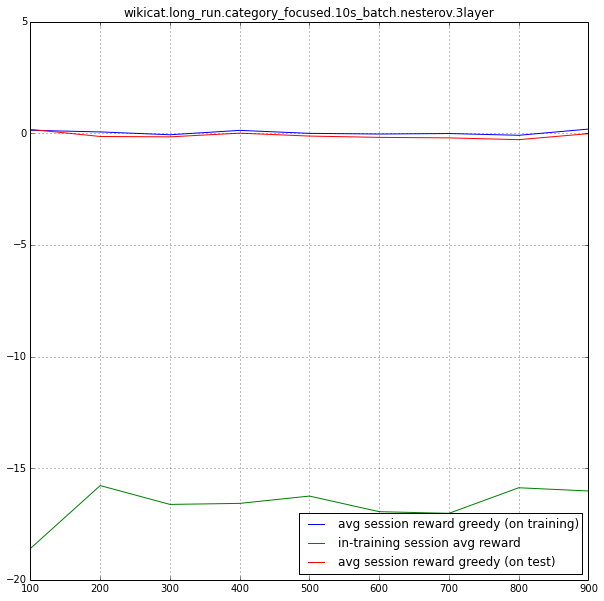

epoch 1000,loss 2.10204, greed 0.20896, rewards: ( train -16.05134, det_train 0.19359) 
rec 2.101 reg 0.001
epoch 1100,loss 1.49039, greed 0.20985, rewards: ( train -15.67062, det_train 0.43423) 
rec 1.489 reg 0.001
epoch 1200,loss 1.13735, greed 0.21074, rewards: ( train -16.88513, det_train 0.55080) 
rec 1.136 reg 0.001
epoch 1300,loss 0.55180, greed 0.21162, rewards: ( train -15.96492, det_train 0.17572) 
rec 0.551 reg 0.001
epoch 1400,loss 2.05327, greed 0.21251, rewards: ( train -16.18422, det_train 0.47815) 
rec 2.052 reg 0.001
epoch 1500,loss 1.53020, greed 0.21340, rewards: ( train -17.55930, det_train 0.53034) 
rec 1.529 reg 0.001
epoch 1600,loss 1.15168, greed 0.21429, rewards: ( train -16.19562, det_train 0.32730) 
rec 1.151 reg 0.001
epoch 1700,loss 1.61978, greed 0.21517, rewards: ( train -16.12001, det_train 0.30457) 
rec 1.619 reg 0.001
epoch 1800,loss 1.23982, greed 0.21606, rewards: ( train -15.90339, det_train 0.09412) 
rec 1.239 reg 0.001
epoch 1900,loss 2.27200, gre

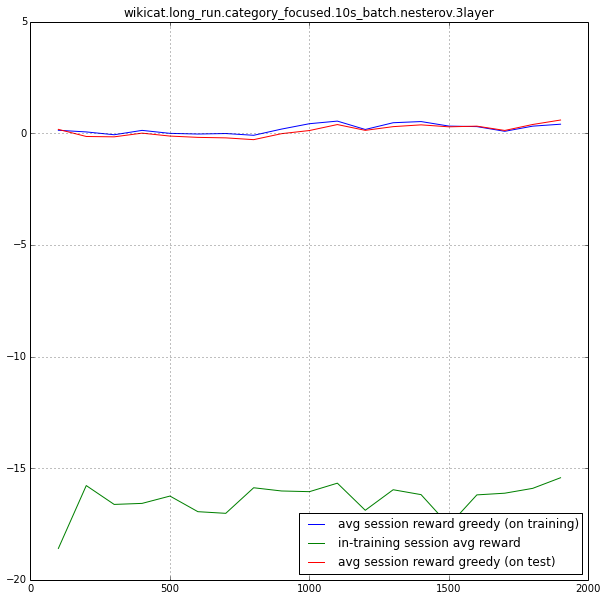

epoch 2000,loss 1.67753, greed 0.21782, rewards: ( train -14.77340, det_train 0.41223) 
rec 1.677 reg 0.001
epoch 2100,loss 1.95304, greed 0.21870, rewards: ( train -15.11321, det_train 0.57101) 
rec 1.952 reg 0.001
epoch 2200,loss 0.76762, greed 0.21958, rewards: ( train -15.29224, det_train 0.85391) 
rec 0.767 reg 0.001
epoch 2300,loss 2.82603, greed 0.22046, rewards: ( train -15.30363, det_train 0.49852) 
rec 2.825 reg 0.001
epoch 2400,loss 1.30836, greed 0.22134, rewards: ( train -15.79532, det_train 0.64867) 
rec 1.307 reg 0.001
epoch 2500,loss 1.04080, greed 0.22222, rewards: ( train -15.50484, det_train 0.86380) 
rec 1.040 reg 0.001
epoch 2600,loss 1.30015, greed 0.22310, rewards: ( train -14.78309, det_train 0.90742) 
rec 1.299 reg 0.001
epoch 2700,loss 0.73062, greed 0.22397, rewards: ( train -14.91966, det_train 1.09668) 
rec 0.730 reg 0.001
epoch 2800,loss 0.78692, greed 0.22485, rewards: ( train -15.60842, det_train 1.30701) 
rec 0.786 reg 0.001
epoch 2900,loss 2.14756, gre

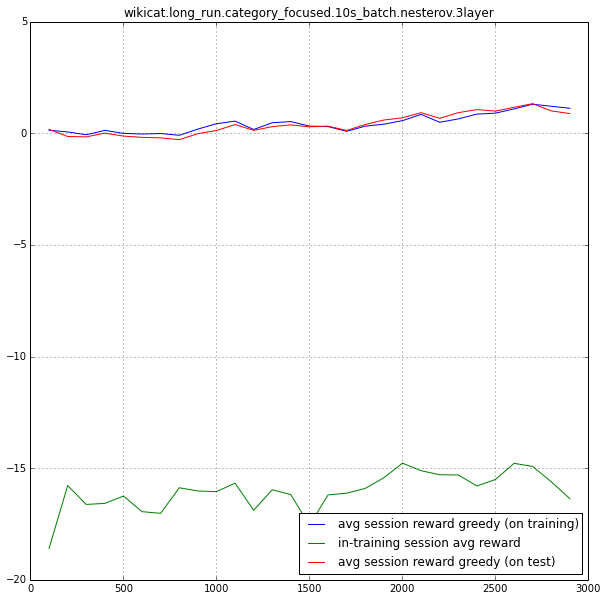

epoch 3000,loss 1.18035, greed 0.22660, rewards: ( train -15.97339, det_train 1.12468) 
rec 1.179 reg 0.001
epoch 3100,loss 3.15122, greed 0.22747, rewards: ( train -15.59026, det_train 1.17221) 
rec 3.150 reg 0.001
epoch 3200,loss 2.05568, greed 0.22834, rewards: ( train -15.68845, det_train 1.32499) 
rec 2.055 reg 0.001
epoch 3300,loss 1.42666, greed 0.22922, rewards: ( train -16.11870, det_train 1.37249) 
rec 1.426 reg 0.001
epoch 3400,loss 2.08142, greed 0.23009, rewards: ( train -15.76550, det_train 1.34524) 
rec 2.080 reg 0.001
epoch 3500,loss 1.21176, greed 0.23096, rewards: ( train -16.60228, det_train 0.96072) 
rec 1.211 reg 0.001
epoch 3600,loss 1.56923, greed 0.23182, rewards: ( train -14.35742, det_train 0.61465) 
rec 1.568 reg 0.001
epoch 3700,loss 1.68289, greed 0.23269, rewards: ( train -14.76925, det_train 0.87318) 
rec 1.682 reg 0.001
epoch 3800,loss 1.54263, greed 0.23356, rewards: ( train -15.33736, det_train 1.11586) 
rec 1.542 reg 0.001
epoch 3900,loss 2.12194, gre

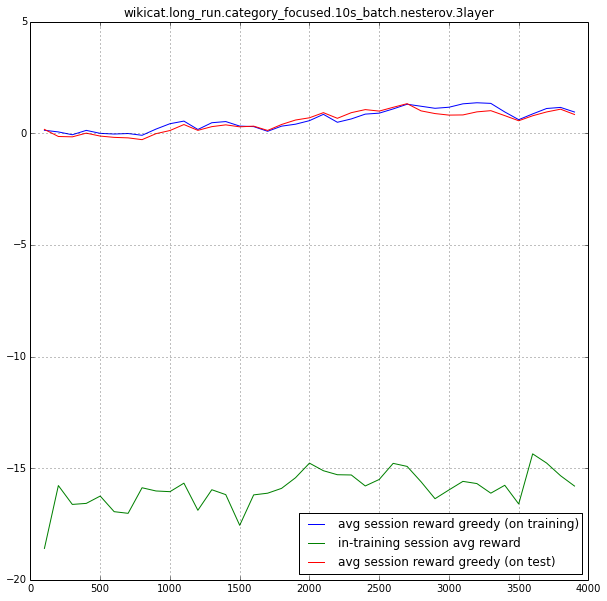

epoch 4000,loss 1.72025, greed 0.23529, rewards: ( train -15.17848, det_train 0.95785) 
rec 1.719 reg 0.001
epoch 4100,loss 0.90429, greed 0.23615, rewards: ( train -14.73764, det_train 0.80206) 
rec 0.903 reg 0.001
epoch 4200,loss 0.99969, greed 0.23702, rewards: ( train -14.97224, det_train 0.80186) 
rec 0.999 reg 0.001
epoch 4300,loss 2.39235, greed 0.23788, rewards: ( train -14.31319, det_train 0.92167) 
rec 2.391 reg 0.001
epoch 4400,loss 1.16822, greed 0.23874, rewards: ( train -16.13782, det_train 1.02950) 
rec 1.167 reg 0.001
epoch 4500,loss 1.66803, greed 0.23960, rewards: ( train -14.74980, det_train 0.92655) 
rec 1.667 reg 0.001
epoch 4600,loss 1.11704, greed 0.24046, rewards: ( train -14.45526, det_train 0.59390) 
rec 1.116 reg 0.001
epoch 4700,loss 1.53647, greed 0.24132, rewards: ( train -15.64664, det_train 0.96451) 
rec 1.535 reg 0.001
epoch 4800,loss 1.06650, greed 0.24218, rewards: ( train -15.12834, det_train 0.53806) 
rec 1.065 reg 0.001
epoch 4900,loss 2.13795, gre

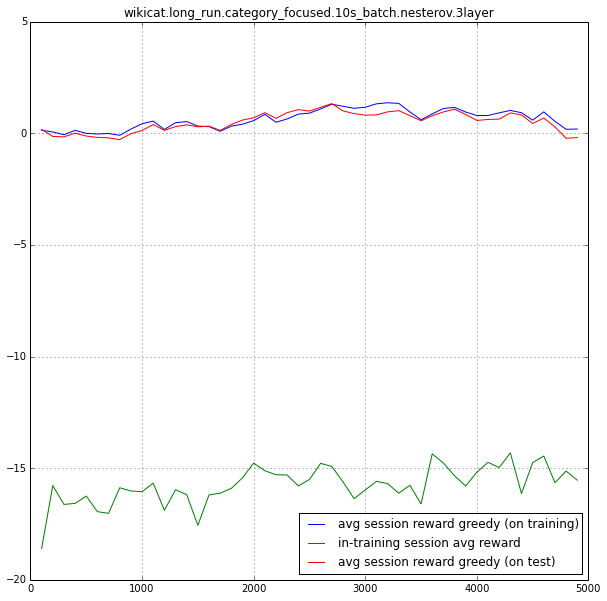

epoch 5000,loss 1.10344, greed 0.24389, rewards: ( train -17.33059, det_train 0.19583) 
rec 1.102 reg 0.001
epoch 5100,loss 1.56218, greed 0.24475, rewards: ( train -14.23827, det_train -0.20376) 
rec 1.561 reg 0.001
epoch 5200,loss 1.03364, greed 0.24560, rewards: ( train -15.31896, det_train 0.03662) 
rec 1.033 reg 0.001
epoch 5300,loss 1.63652, greed 0.24646, rewards: ( train -14.98465, det_train 0.39296) 
rec 1.635 reg 0.001
epoch 5400,loss 0.78472, greed 0.24731, rewards: ( train -15.31450, det_train 0.67366) 
rec 0.784 reg 0.001
epoch 5500,loss 1.08443, greed 0.24816, rewards: ( train -14.24403, det_train 0.08630) 
rec 1.083 reg 0.001
epoch 5600,loss 1.05353, greed 0.24901, rewards: ( train -15.72719, det_train 0.20767) 
rec 1.052 reg 0.001
epoch 5700,loss 0.91442, greed 0.24987, rewards: ( train -14.68216, det_train 0.44690) 
rec 0.913 reg 0.001
epoch 5800,loss 0.85970, greed 0.25072, rewards: ( train -14.15210, det_train 0.43221) 
rec 0.859 reg 0.001
epoch 5900,loss 1.21385, gr

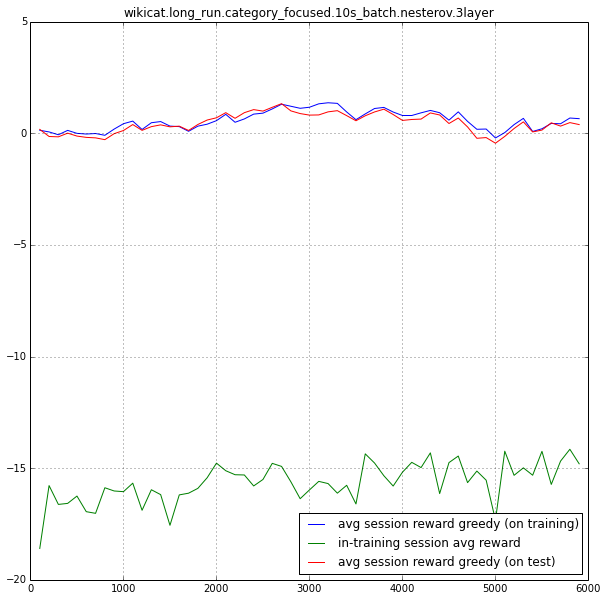

epoch 6000,loss 0.70439, greed 0.25241, rewards: ( train -15.17556, det_train 0.66009) 
rec 0.703 reg 0.001
epoch 6100,loss 1.32594, greed 0.25326, rewards: ( train -14.28717, det_train 0.51408) 
rec 1.325 reg 0.001
epoch 6200,loss 0.76155, greed 0.25411, rewards: ( train -15.09282, det_train 0.12267) 
rec 0.760 reg 0.001
epoch 6300,loss 1.87427, greed 0.25495, rewards: ( train -14.30171, det_train 0.03041) 
rec 1.873 reg 0.001
epoch 6400,loss 1.70454, greed 0.25580, rewards: ( train -14.57563, det_train 0.18736) 
rec 1.703 reg 0.001
epoch 6500,loss 0.72525, greed 0.25664, rewards: ( train -14.63800, det_train 0.39863) 
rec 0.724 reg 0.001
epoch 6600,loss 1.33443, greed 0.25748, rewards: ( train -14.10167, det_train 0.39877) 
rec 1.333 reg 0.001
epoch 6700,loss 0.84460, greed 0.25832, rewards: ( train -14.49758, det_train 0.61889) 
rec 0.844 reg 0.001
epoch 6800,loss 0.67181, greed 0.25917, rewards: ( train -13.90040, det_train 0.38700) 
rec 0.671 reg 0.001
epoch 6900,loss 1.08219, gre

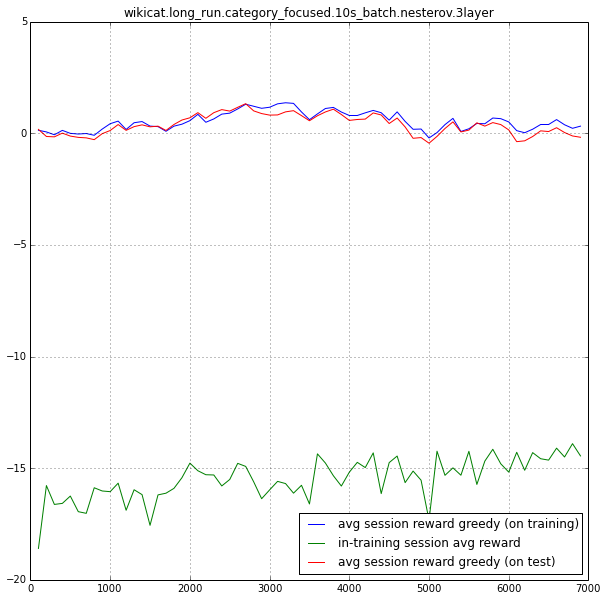

epoch 7000,loss 0.54125, greed 0.26085, rewards: ( train -13.32837, det_train 0.32547) 
rec 0.540 reg 0.001
epoch 7100,loss 1.25159, greed 0.26168, rewards: ( train -14.46010, det_train 0.83292) 
rec 1.251 reg 0.001
epoch 7200,loss 0.84923, greed 0.26252, rewards: ( train -14.25642, det_train 0.97963) 
rec 0.848 reg 0.001
epoch 7300,loss 0.61562, greed 0.26336, rewards: ( train -13.33307, det_train 1.24167) 
rec 0.615 reg 0.001
epoch 7400,loss 0.72471, greed 0.26420, rewards: ( train -13.65507, det_train 1.43750) 
rec 0.724 reg 0.001
epoch 7500,loss 0.54268, greed 0.26503, rewards: ( train -14.06419, det_train 1.31375) 
rec 0.542 reg 0.001
epoch 7600,loss 0.66446, greed 0.26587, rewards: ( train -13.39242, det_train 1.31238) 
rec 0.663 reg 0.001
epoch 7700,loss 0.89434, greed 0.26670, rewards: ( train -13.89390, det_train 1.27114) 
rec 0.893 reg 0.001
epoch 7800,loss 0.88226, greed 0.26753, rewards: ( train -14.12456, det_train 1.52402) 
rec 0.881 reg 0.001
epoch 7900,loss 0.66837, gre

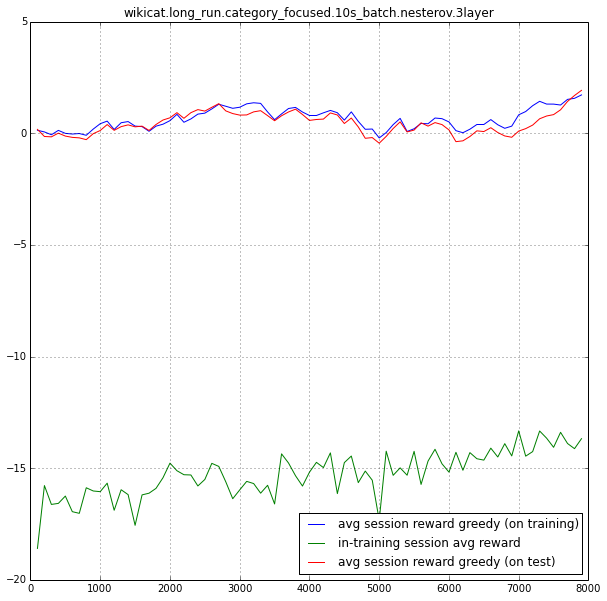

epoch 8000,loss 0.82620, greed 0.26920, rewards: ( train -13.54898, det_train 1.72446) 
rec 0.825 reg 0.001
epoch 8100,loss 0.70181, greed 0.27003, rewards: ( train -13.44994, det_train 1.89201) 
rec 0.701 reg 0.001
epoch 8200,loss 0.77885, greed 0.27086, rewards: ( train -13.79839, det_train 1.97281) 
rec 0.778 reg 0.001
epoch 8300,loss 0.74595, greed 0.27168, rewards: ( train -13.59371, det_train 1.39553) 
rec 0.745 reg 0.001
epoch 8400,loss 0.92868, greed 0.27251, rewards: ( train -13.39574, det_train 1.28598) 
rec 0.928 reg 0.001
epoch 8500,loss 0.86674, greed 0.27334, rewards: ( train -15.36815, det_train 1.55738) 
rec 0.866 reg 0.001
epoch 8600,loss 0.83744, greed 0.27417, rewards: ( train -13.30391, det_train 1.37164) 
rec 0.836 reg 0.001
epoch 8700,loss 0.84253, greed 0.27499, rewards: ( train -13.63680, det_train 1.28448) 
rec 0.841 reg 0.001
epoch 8800,loss 0.62305, greed 0.27582, rewards: ( train -14.03441, det_train 1.35603) 
rec 0.622 reg 0.001
epoch 8900,loss 0.49763, gre

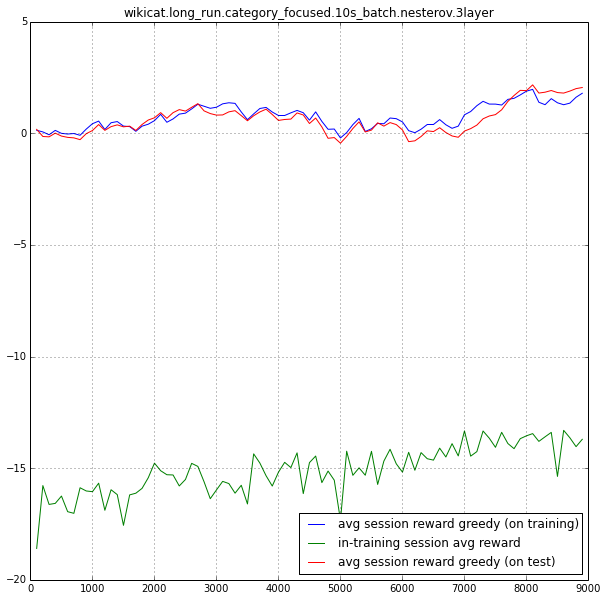

epoch 9000,loss 0.83230, greed 0.27746, rewards: ( train -14.39884, det_train 1.79838) 
rec 0.831 reg 0.001
epoch 9100,loss 0.53908, greed 0.27828, rewards: ( train -13.98516, det_train 1.89855) 
rec 0.538 reg 0.001
epoch 9200,loss 0.64005, greed 0.27911, rewards: ( train -13.92925, det_train 2.02869) 
rec 0.639 reg 0.001
epoch 9300,loss 1.47236, greed 0.27993, rewards: ( train -12.77859, det_train 2.12582) 
rec 1.471 reg 0.001
epoch 9400,loss 0.78118, greed 0.28075, rewards: ( train -13.78590, det_train 2.31324) 
rec 0.780 reg 0.001
epoch 9500,loss 1.15801, greed 0.28156, rewards: ( train -13.93080, det_train 2.20192) 
rec 1.157 reg 0.001
epoch 9600,loss 1.18302, greed 0.28238, rewards: ( train -13.94725, det_train 2.12172) 
rec 1.182 reg 0.001
epoch 9700,loss 0.88871, greed 0.28320, rewards: ( train -12.69912, det_train 1.61955) 
rec 0.888 reg 0.001
epoch 9800,loss 0.78185, greed 0.28402, rewards: ( train -13.83238, det_train 1.64760) 
rec 0.781 reg 0.001
epoch 9900,loss 0.84534, gre

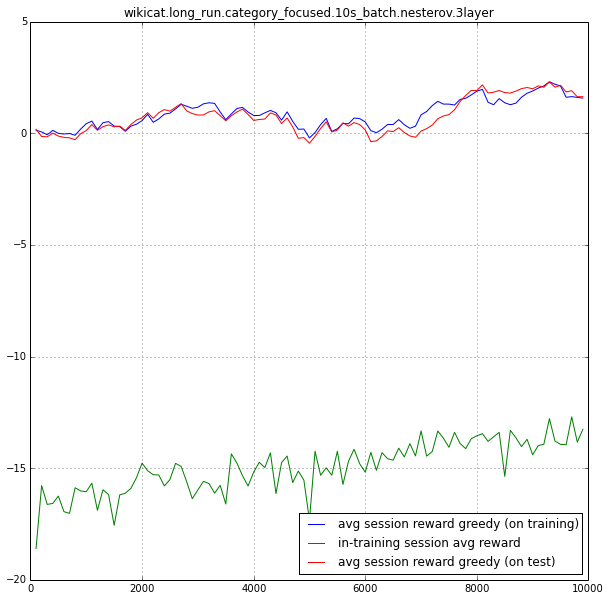

epoch 10000,loss 0.75242, greed 0.28565, rewards: ( train -13.19971, det_train 1.58155) 
rec 0.751 reg 0.001
epoch 10100,loss 0.74108, greed 0.28646, rewards: ( train -12.74324, det_train 1.69340) 
rec 0.740 reg 0.001
epoch 10200,loss 0.74978, greed 0.28727, rewards: ( train -12.47648, det_train 1.88406) 
rec 0.749 reg 0.001
epoch 10300,loss 0.98277, greed 0.28809, rewards: ( train -13.66859, det_train 2.06565) 
rec 0.982 reg 0.001
epoch 10400,loss 0.79501, greed 0.28890, rewards: ( train -13.15057, det_train 2.10909) 
rec 0.794 reg 0.001
epoch 10500,loss 0.73998, greed 0.28971, rewards: ( train -13.42171, det_train 2.21818) 
rec 0.739 reg 0.001
epoch 10600,loss 0.84182, greed 0.29052, rewards: ( train -13.22248, det_train 2.29636) 
rec 0.841 reg 0.001
epoch 10700,loss 0.67252, greed 0.29133, rewards: ( train -12.76738, det_train 2.44672) 
rec 0.671 reg 0.001
epoch 10800,loss 0.53964, greed 0.29214, rewards: ( train -12.94034, det_train 2.48205) 

In [ ]:
n_epochs = 10**6
batch_size=10
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/100000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1)
        
        plot_scores(experiment_setup_name)

    if epoch_counter% 25000 ==0:
        save(resolver,"/root/agentnet_snapshots/{}.epoch{}.pcl".format(experiment_setup_name,epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy

        #greedy test
        set_shared(resolver.epsilon,0)
        load_random_batch(env,test_attrs,test_cats,batch_size=batch_size)

        avg_reward_test = loss_fun()[-1]
        ma_reward_test = (1-alpha)*ma_reward_test + alpha*avg_reward_test
        score_log["avg session reward greedy (on test)"][epoch_counter] = ma_reward_test
        

        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


In [ ]:
plot_scores("final")

In [ ]:
load_random_batch(env,train_attrs,train_cats,10)
print_session(10)

In [ ]:
print_session(display=True,legend=False)

In [47]:
load_random_batch(env,test_attrs,test_cats,10)
print_session(10)

#26: decades_active:2010 (4.968) -> 1.0 | #25: last_activity:still_active (4.757) -> 1.0 | #166: decades_active:2000 (3.996) -> 1.0 | #149: Labels:is_known (3.175) -> 1.0 | #260: decades_active:1990 (2.660) -> -1.0 | #247: Website:is_known (2.302) -> 1.0 | #1: Birth name:is_known (1.630) -> 1.0 | #25: last_activity:still_active (1.160) -> 0.0 | #20: Instruments:vocals (1.224) -> 1.0 | #272: Occupation:artist (-0.104) -> -1.0 | #75: Occupation:singer (0.737) -> 1.0 | #246: Occupation:songwriter (0.805) -> -1.0 | #26: decades_active:2010 (-0.022) -> 0.0 | #26: decades_active:2010 (-0.013) -> 0.0 | #26: decades_active:2010 (-0.010) -> 0.0 | #26: decades_active:2010 (-0.004) -> 0.0 | #26: decades_active:2010 (0.002) -> 0.0 | #385: category:List_of_Scottish_musicians (-1.018) -> -1.0 | #26: decades_active:2010 (-0.012) -> 0.0 | #26: decades_active:2010 (-0.011) -> 0.0 | <end>
true: category:List_of_female_heavy_metal_singers

#259: Genres:alternative (3.849) -> -1.0 | #26: decades_active:20

#26: decades_active:2010 (4.968) -> 1.0 | #25: last_activity:still_active (4.757) -> 1.0 | #166: decades_active:2000 (3.996) -> 1.0 | #149: Labels:is_known (3.175) -> 1.0 | #48: Genres:bluegrass (1.435) -> -1.0 | #336: category:List_of_Dutch_musicians (1.353) -> -1.0 | #260: decades_active:1990 (2.553) -> -1.0 | #247: Website:is_known (2.124) -> 1.0 | #1: Birth name:is_known (1.532) -> 1.0 | #149: Labels:is_known (1.065) -> 0.0 | #20: Instruments:vocals (1.023) -> 1.0 | #247: Website:is_known (0.547) -> 0.0 | #3: Instruments:guitar (0.296) -> -1.0 | #75: Occupation:singer (0.444) -> 1.0 | #246: Occupation:songwriter (0.489) -> -1.0 | #26: decades_active:2010 (0.011) -> 0.0 | #26: decades_active:2010 (0.010) -> 0.0 | #26: decades_active:2010 (0.007) -> 0.0 | #26: decades_active:2010 (-0.003) -> 0.0 | #25: last_activity:still_active (-0.011) -> 0.0 | <end>
true: category:List_of_female_heavy_metal_singers


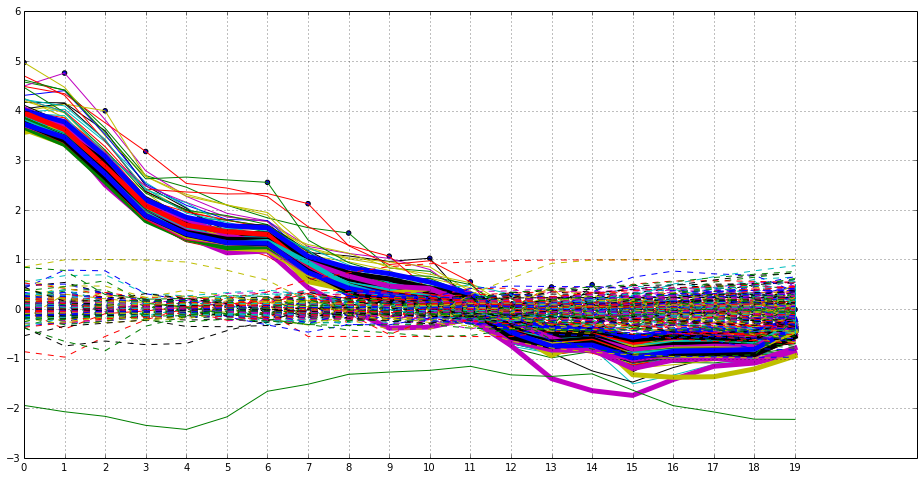


#26: decades_active:2010 (4.968) -> 1.0 | #25: last_activity:still_active (4.757) -> 1.0 | #166: decades_active:2000 (3.996) -> 1.0 | #149: Labels:is_known (3.175) -> -1.0 | #260: decades_active:1990 (2.739) -> 1.0 | #129: Genres:southern (1.076) -> -1.0 | #91: decades_active:1980 (2.039) -> 1.0 | #221: decades_active:1970 (1.668) -> -1.0 | #1: Birth name:is_known (1.090) -> -1.0 | #247: Website:is_known (0.744) -> -1.0 | #262: Occupation:musician (0.692) -> -1.0 | #26: decades_active:2010 (-0.027) -> 0.0 | #26: decades_active:2010 (0.009) -> 0.0 | #26: decades_active:2010 (0.006) -> 0.0 | #26: decades_active:2010 (-0.014) -> 0.0 | #26: decades_active:2010 (-0.018) -> 0.0 | #26: decades_active:2010 (0.003) -> 0.0 | #26: decades_active:2010 (0.016) -> 0.0 | #25: last_activity:still_active (0.004) -> 0.0 | #26: decades_active:2010 (0.016) -> 0.0 | <end>
true: category:List_of_performers_on_Top_of_the_Pops


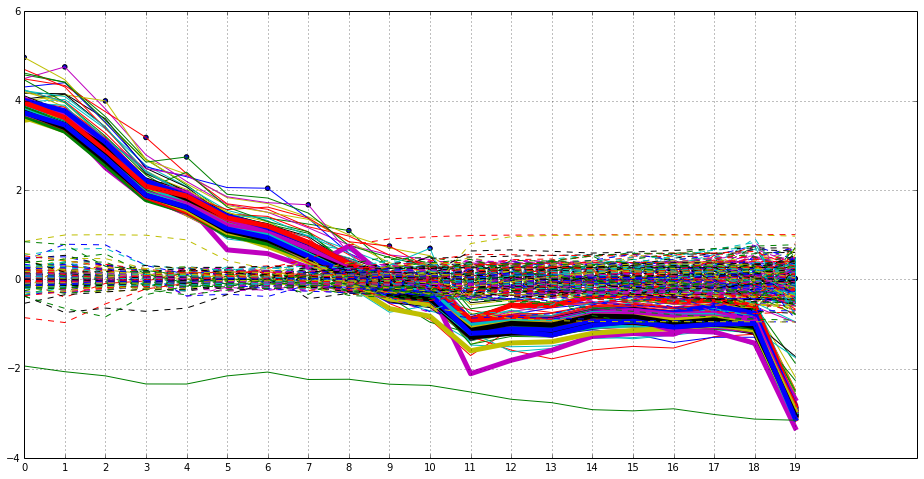


#26: decades_active:2010 (4.968) -> 1.0 | #25: last_activity:still_active (4.757) -> 1.0 | #166: decades_active:2000 (3.996) -> 1.0 | #149: Labels:is_known (3.175) -> 1.0 | #284: last_activity:1989 (1.421) -> -1.0 | #260: decades_active:1990 (2.628) -> -1.0 | #247: Website:is_known (2.262) -> 1.0 | #24: Genres:psychedelic (0.396) -> -1.0 | #1: Birth name:is_known (1.468) -> -1.0 | #20: Instruments:vocals (0.884) -> -1.0 | #75: Occupation:singer (0.103) -> 1.0 | #108: Genres:r&b (0.159) -> 1.0 | #26: decades_active:2010 (-0.000) -> 0.0 | #26: decades_active:2010 (0.009) -> 0.0 | #26: decades_active:2010 (0.013) -> 0.0 | #26: decades_active:2010 (0.012) -> 0.0 | #17: Home town:is_known (-0.863) -> -1.0 | #26: decades_active:2010 (0.018) -> 0.0 | #26: decades_active:2010 (-0.005) -> 0.0 | #26: decades_active:2010 (-0.009) -> 0.0 | <end>
true: category:List_of_individual_K-pop_artists


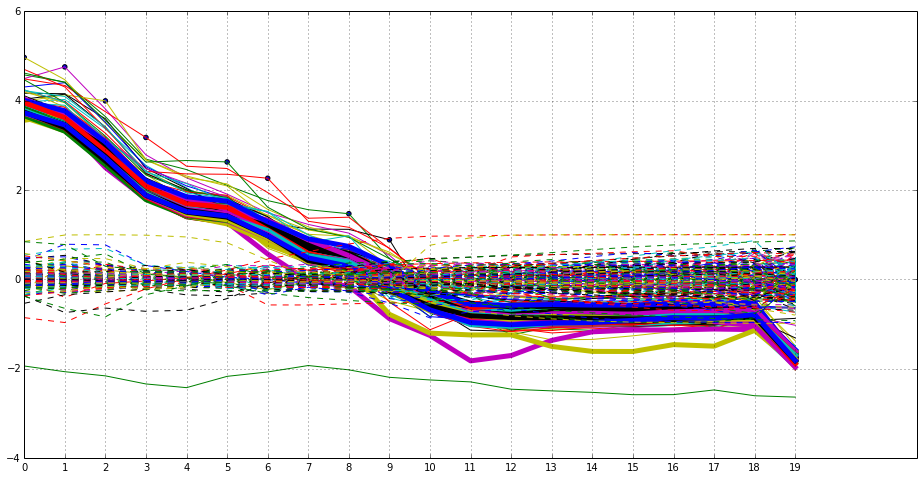

In [48]:
print_session(display=True,legend=False)